<a href="https://colab.research.google.com/github/narendrapatel6321-dotcom/CV---Assignments/blob/main/25N0242_CV_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets segment-anything omegaconf segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.8 MB/s eta 0:00:00


In [2]:
import os, time, cv2, torch, random
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset
from segment_anything import sam_model_registry, SamPredictor
from sklearn.metrics import confusion_matrix
import seaborn as sns
import segmentation_models_pytorch as smp
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available:", device)

Device available: cuda


In [4]:
dataset = load_dataset("nateraw/pascal-voc-2012", split="train")
val_dataset = load_dataset("nateraw/pascal-voc-2012", split="val")
print("Dataset loaded.")

dataset_infos.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/166M [00:00<?, ?B/s]

data/val-00000-of-00001.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1464 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1449 [00:00<?, ? examples/s]

Dataset loaded.


In [5]:
# VOC 21 classes
VOC_COLORS = [
    (0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0),
    (0, 0, 128), (128, 0, 128), (0, 128, 128), (128, 128, 128),
    (64, 0, 0), (192, 0, 0), (64, 128, 0), (192, 128, 0),
    (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
    (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)
]

In [6]:
# Convert RGB mask to label IDs
def rgb_to_mask(mask):
    mask = np.array(mask)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int64)
    for idx, color in enumerate(VOC_COLORS):
        equality = np.all(mask == color, axis=-1)
        label_mask[equality] = idx
    return torch.from_numpy(label_mask)

In [7]:
# Dataset Class
class VOCSegHFDataset(Dataset):
    def __init__(self, hf_dataset, img_transform=None, mask_transform=None, sam_vis_transform=None):
        self.dataset = hf_dataset
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.sam_vis_transform = sam_vis_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        img = sample['image']
        mask = sample['mask']

        img_vis = self.sam_vis_transform(img) if self.sam_vis_transform else None
        img = self.img_transform(img) if self.img_transform else img

        mask = rgb_to_mask(mask)
        mask = self.mask_transform(Image.fromarray(mask.numpy().astype(np.uint8))) if self.mask_transform else mask
        mask = mask.long()
        return img, mask, img_vis

In [8]:
# Transforms
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_img_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.3,0.3,0.3,0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

val_img_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

sam_vis_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((320,320), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze(0))
])


In [9]:
# Datasets
train_ds = VOCSegHFDataset(dataset, img_transform=train_img_transform,
                           mask_transform=mask_transform,
                           sam_vis_transform=sam_vis_transform)
val_ds = VOCSegHFDataset(val_dataset, img_transform=val_img_transform,
                         mask_transform=mask_transform,
                         sam_vis_transform=sam_vis_transform)

In [10]:
val_size = int(0.5*len(val_ds))
test_size = len(val_ds) - val_size
val_subset, test_subset = random_split(val_ds, [val_size, test_size])

# DataLoaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_subset, batch_size=16)
test_dl = DataLoader(test_subset, batch_size=16)

In [11]:
# Loss Functions
class DiceLoss(nn.Module):
    def __init__(self, num_classes, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        targets_one_hot = nn.functional.one_hot(targets, self.num_classes).permute(0,3,1,2)
        probs_flat = probs.view(probs.shape[0], self.num_classes, -1)
        targets_flat = targets_one_hot.view(targets_one_hot.shape[0], self.num_classes, -1).float()
        intersection = (probs_flat * targets_flat).sum(dim=2)
        union = probs_flat.sum(dim=2) + targets_flat.sum(dim=2)
        dice = (2.*intersection + self.smooth)/(union + self.smooth)
        return 1 - dice.mean()

In [12]:
class CombinedLoss(nn.Module):
    def __init__(self, num_classes, ce_weight=0.5):
        super().__init__()
        self.ce_weight = ce_weight
        weights = torch.tensor([1.0] + [3.0]*20).to(device)
        self.ce = nn.CrossEntropyLoss(weight=weights)
        self.dice = DiceLoss(num_classes)

    def forward(self, logits, targets):
        return self.ce_weight*self.ce(logits,targets) + (1-self.ce_weight)*self.dice(logits,targets)

In [13]:
def pixel_accuracy(preds, labels):
    return (preds==labels).sum().item()/labels.numel()

def dice_coefficient(preds, labels, num_classes=21, smooth=1e-6):
    dice = 0
    for c in range(num_classes):
        pred_c = (preds==c).float()
        label_c = (labels==c).float()
        intersection = (pred_c*label_c).sum()
        dice += (2.*intersection + smooth)/(pred_c.sum()+label_c.sum()+smooth)
    return dice/num_classes

def mean_iou(preds, labels, num_classes=21):
    ious=[]
    for c in range(num_classes):
        pred_c = (preds==c).float()
        label_c = (labels==c).float()
        intersection = (pred_c*label_c).sum()
        union = (pred_c+label_c-pred_c*label_c).sum()
        ious.append((intersection/union).item() if union>0 else np.nan)
    return np.nanmean(ious)

In [14]:
# Model
model = smp.Unet(encoder_name="resnet34",
                 encoder_weights="imagenet",
                 in_channels=3, classes=21).to(device)

criterion = CombinedLoss(num_classes=21).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='max',
                                                       factor=0.5, patience=2)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [15]:
# Training
num_epochs = 35
best_val_miou = 0.0
MODEL_SAVE_PATH = "best_unet_model.pth"

scaler = torch.amp.GradScaler()  # mixed precision

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for imgs, masks, _ in tqdm(train_dl):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(imgs)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    avg_train_loss = total_loss/len(train_dl)

    # Validation
    model.eval()
    val_pixel_acc, val_dice, val_miou = [], [], []
    with torch.no_grad():
        for imgs, masks, _ in val_dl:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            val_pixel_acc.append(pixel_accuracy(preds,masks))
            val_dice.append(dice_coefficient(preds,masks).item())
            val_miou.append(mean_iou(preds,masks).item())
    current_val_miou = np.nanmean(val_miou)
    scheduler.step(current_val_miou)

    if current_val_miou>best_val_miou:
        best_val_miou=current_val_miou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"*** New best model saved with mIoU: {best_val_miou:.4f} ***")

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | "
          f"Val Pixel Acc: {np.mean(val_pixel_acc):.4f} | Val Dice: {np.mean(val_dice):.4f} | Val mIoU: {current_val_miou:.4f}")

100%|██████████| 92/92 [03:50<00:00,  2.51s/it]


*** New best model saved with mIoU: 0.0779 ***
Epoch [1/35] Train Loss: 1.8075 | Val Pixel Acc: 0.4898 | Val Dice: 0.1176 | Val mIoU: 0.0779


100%|██████████| 92/92 [03:42<00:00,  2.42s/it]


*** New best model saved with mIoU: 0.1317 ***
Epoch [2/35] Train Loss: 1.4804 | Val Pixel Acc: 0.6687 | Val Dice: 0.1942 | Val mIoU: 0.1317


100%|██████████| 92/92 [03:44<00:00,  2.44s/it]


*** New best model saved with mIoU: 0.1741 ***
Epoch [3/35] Train Loss: 1.3008 | Val Pixel Acc: 0.7785 | Val Dice: 0.3209 | Val mIoU: 0.1741


100%|██████████| 92/92 [03:41<00:00,  2.41s/it]


*** New best model saved with mIoU: 0.1946 ***
Epoch [4/35] Train Loss: 1.1918 | Val Pixel Acc: 0.7920 | Val Dice: 0.3834 | Val mIoU: 0.1946


100%|██████████| 92/92 [03:40<00:00,  2.40s/it]


*** New best model saved with mIoU: 0.2187 ***
Epoch [5/35] Train Loss: 1.1291 | Val Pixel Acc: 0.8060 | Val Dice: 0.3988 | Val mIoU: 0.2187


100%|██████████| 92/92 [03:41<00:00,  2.41s/it]


Epoch [6/35] Train Loss: 1.0852 | Val Pixel Acc: 0.7982 | Val Dice: 0.4130 | Val mIoU: 0.2141


100%|██████████| 92/92 [03:42<00:00,  2.41s/it]


*** New best model saved with mIoU: 0.2360 ***
Epoch [7/35] Train Loss: 1.0474 | Val Pixel Acc: 0.8044 | Val Dice: 0.4374 | Val mIoU: 0.2360


100%|██████████| 92/92 [03:40<00:00,  2.40s/it]


Epoch [8/35] Train Loss: 1.0116 | Val Pixel Acc: 0.8023 | Val Dice: 0.4149 | Val mIoU: 0.2313


100%|██████████| 92/92 [03:41<00:00,  2.41s/it]


*** New best model saved with mIoU: 0.2461 ***
Epoch [9/35] Train Loss: 0.9887 | Val Pixel Acc: 0.8050 | Val Dice: 0.4429 | Val mIoU: 0.2461


100%|██████████| 92/92 [03:40<00:00,  2.40s/it]


*** New best model saved with mIoU: 0.2544 ***
Epoch [10/35] Train Loss: 0.9579 | Val Pixel Acc: 0.8097 | Val Dice: 0.4622 | Val mIoU: 0.2544


100%|██████████| 92/92 [03:39<00:00,  2.39s/it]


Epoch [11/35] Train Loss: 0.9369 | Val Pixel Acc: 0.7879 | Val Dice: 0.4113 | Val mIoU: 0.2370


100%|██████████| 92/92 [03:41<00:00,  2.40s/it]


*** New best model saved with mIoU: 0.2733 ***
Epoch [12/35] Train Loss: 0.9204 | Val Pixel Acc: 0.8107 | Val Dice: 0.4720 | Val mIoU: 0.2733


 92%|█████████▏| 85/92 [03:26<00:17,  2.43s/it]


KeyboardInterrupt: 

### Stopped training early because of lack of resources

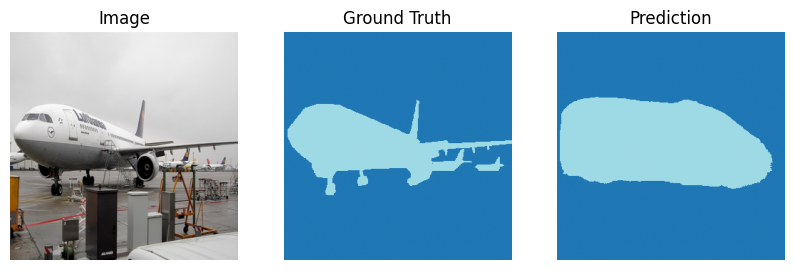

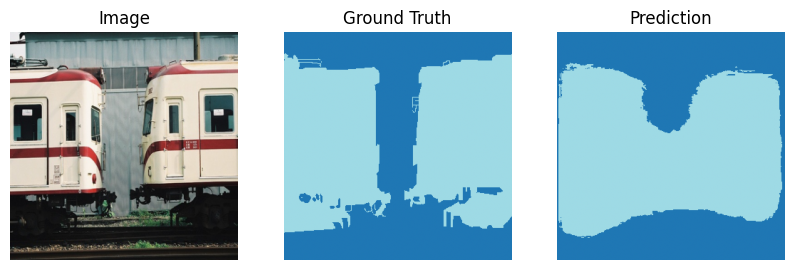

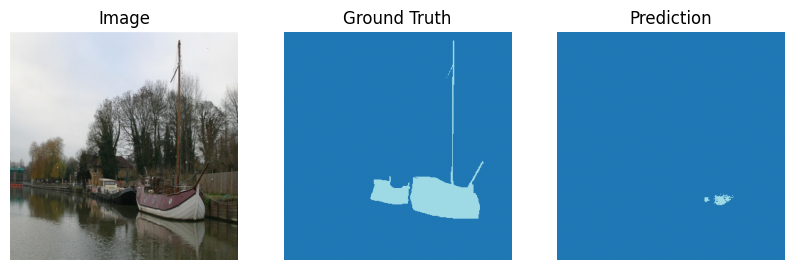

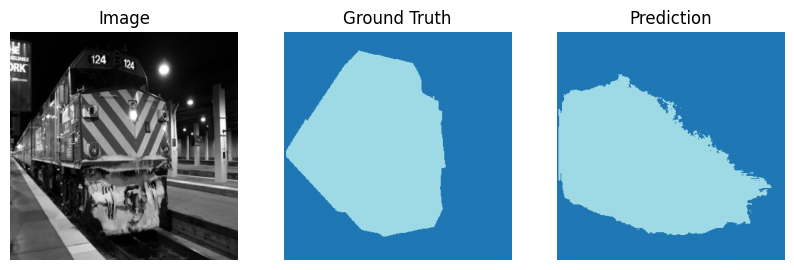

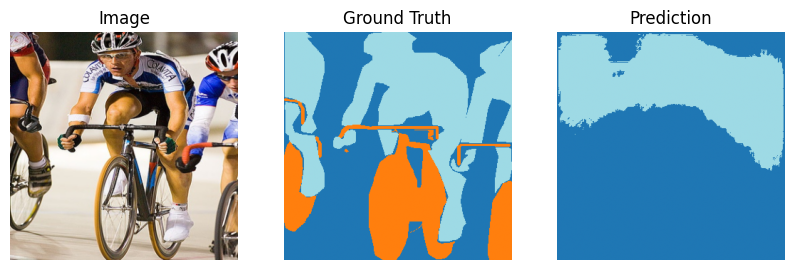

In [16]:
# Visualization function
def visualize_predictions(dataset, model, num_samples=5):
    model.eval()
    device = next(model.parameters()).device
    for i in range(num_samples):
        img, mask, img_vis = dataset[i]
        img_input = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_input)
            pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # Use the unnormalized image for visualization
        img_np = img_vis.permute(1,2,0).numpy()
        mask_np = mask.numpy()

        plt.figure(figsize=(10,4))
        plt.subplot(1,3,1)
        plt.imshow(img_np)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask_np, cmap='tab20')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap='tab20')
        plt.title("Prediction")
        plt.axis('off')

        plt.show()

# Run visualization
visualize_predictions(val_ds, model, num_samples=5)

In [17]:
print(f"\nLoading best model from {MODEL_SAVE_PATH} (Best Val mIoU: {best_val_miou:.4f})")
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model = model.to(device)


Loading best model from best_unet_model.pth (Best Val mIoU: 0.2733)


In [18]:
# Helper Functions for Segmentation Metrics and Visualization

def iou_binary(pred, target, smooth=1e-6):
    """Binary IoU between pred and target (both boolean tensors)"""
    pred = pred.bool()
    target = target.bool()
    intersection = (pred & target).sum().float()
    union = (pred | target).sum().float()
    return (intersection / (union + smooth)).item()

def dice_binary(pred, target, smooth=1e-6):
    """Binary Dice coefficient"""
    pred = pred.bool()
    target = target.bool()
    intersection = (pred & target).sum().float()
    return (2. * intersection / (pred.sum().float() + target.sum().float() + smooth)).item()

def get_bbox_from_mask(mask_tensor):
    """Calculates bounding box [x_min, y_min, x_max, y_max] from a binary mask"""
    coords = mask_tensor.nonzero()
    if coords.shape[0] == 0:
        return None  # No object
    y_min, x_min = coords.min(dim=0).values
    y_max, x_max = coords.max(dim=0).values
    return torch.tensor([x_min, y_min, x_max, y_max], device=mask_tensor.device)

def global_pixel_accuracy(preds, labels):
    """Global pixel accuracy for multi-class segmentation"""
    return (preds == labels).sum().item() / labels.numel()

def precision_binary(pred, target, smooth=1e-6):
    pred = pred.bool()
    target = target.bool()
    tp = (pred & target).sum().float()
    fp = (pred & ~target).sum().float()
    return (tp / (tp + fp + smooth)).item()

def recall_binary(pred, target, smooth=1e-6):
    pred = pred.bool()
    target = target.bool()
    tp = (pred & target).sum().float()
    fn = (~pred & target).sum().float()
    return (tp / (tp + fn + smooth)).item()

def f1_binary(pred, target, smooth=1e-6):
    """Binary F1 score"""
    prec = precision_binary(pred, target, smooth)
    rec = recall_binary(pred, target, smooth)
    return 2 * (prec * rec) / (prec + rec + smooth)

def mask_to_rgb(mask, colors):
    """Convert class mask (H, W) to RGB image (H, W, 3)"""
    colors_np = np.array(colors, dtype=np.uint8)
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for c_idx in range(len(colors)):
        rgb_mask[mask == c_idx] = colors_np[c_idx]
    return rgb_mask

# Multi-class convenience functions

def per_class_iou(preds, labels, num_classes=21):
    """Compute IoU for each class"""
    ious = []
    for c in range(num_classes):
        ious.append(iou_binary(preds==c, labels==c))
    return ious

def per_class_dice(preds, labels, num_classes=21):
    """Compute Dice for each class"""
    dices = []
    for c in range(num_classes):
        dices.append(dice_binary(preds==c, labels==c))
    return dices

def per_class_f1(preds, labels, num_classes=21):
    """Compute F1 for each class"""
    f1s = []
    for c in range(num_classes):
        f1s.append(f1_binary(preds==c, labels==c))
    return f1s


In [20]:
# Load SAM
model_type = "vit_b"
checkpoint_path = "sam_vit_b.pth"

# Download the checkpoint if it doesn't exist
if not os.path.exists(checkpoint_path):
    print(f"Downloading SAM checkpoint to {checkpoint_path}...")
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O {checkpoint_path}
    print("Download complete.")


sam = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device)
predictor = SamPredictor(sam)
print("SAM model loaded.")

# Evaluate both models
num_classes = 21  # 20 classes + 1 background
unet_time = []
sam_time = []

--2025-11-04 09:12:56--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 54.240.184.92, 54.240.184.75, 54.240.184.91, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|54.240.184.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b.pth’

sam_vit_b.pth       100%[===================>] 357.67M   272MB/s    in 1.3s    

2025-11-04 09:12:57 (272 MB/s) - ‘sam_vit_b.pth’ saved [375042383/375042383]

Download complete.
SAM model loaded.


In [21]:
#  Define test_subset from val_ds
val_size = int(0.5 * len(val_ds))
test_size = len(val_ds) - val_size
_, test_subset = random_split(val_ds, [val_size, test_size])


# Store scores for each class
unet_class_iou = [[] for _ in range(num_classes)]
unet_class_dice = [[] for _ in range(num_classes)]
unet_class_precision = [[] for _ in range(num_classes)]
unet_class_recall = [[] for _ in range(num_classes)]
unet_class_f1 = [[] for _ in range(num_classes)]
unet_acc_scores = [] # For global accuracy
unet_cm_total = np.zeros((num_classes, num_classes), dtype=np.int64)

sam_class_iou = [[] for _ in range(num_classes)]
sam_class_dice = [[] for _ in range(num_classes)]
sam_class_precision = [[] for _ in range(num_classes)]
sam_class_recall = [[] for _ in range(num_classes)]
sam_class_f1 = [[] for _ in range(num_classes)]
sam_acc_scores = [] # For global accuracy
sam_cm_total = np.zeros((num_classes, num_classes), dtype=np.int64)


In [22]:
print(f"\nRunning final evaluation on 500 test samples...")

eval_samples_indices = range(min(500, len(test_subset)))
model.eval()
for idx in tqdm(eval_samples_indices):
    img, gt_mask, img_vis = test_subset[idx]  # img (3,320,320), gt_mask (320,320), img_vis (3,320,320)
    img_tensor = img.unsqueeze(0).to(device)
    gt_mask_device = gt_mask.to(device)

    # U-Net Inference
    start_unet = time.time()
    with torch.no_grad():
        unet_out = model(img_tensor)
        unet_preds_multi = torch.argmax(unet_out, dim=1).squeeze(0)  # (H,W)
    end_unet = time.time()
    unet_time.append(end_unet - start_unet)

    unet_acc_scores.append(global_pixel_accuracy(unet_preds_multi, gt_mask_device))

    # SAM Image Setup
    img_np = (img_vis.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    predictor.set_image(img_np)

    sam_final_mask = torch.zeros_like(gt_mask_device)
    total_sam_time_for_image = 0

    # Iterate over each class
    for c in range(1, num_classes):
        gt_class_mask = (gt_mask_device == c)
        if gt_class_mask.sum() == 0:
            continue  # skip if class not present

        # U-Net Metrics
        unet_class_mask = (unet_preds_multi == c)
        unet_class_iou[c].append(iou_binary(unet_class_mask, gt_class_mask))
        unet_class_dice[c].append(dice_binary(unet_class_mask, gt_class_mask))
        unet_class_precision[c].append(precision_binary(unet_class_mask, gt_class_mask))
        unet_class_recall[c].append(recall_binary(unet_class_mask, gt_class_mask))
        unet_class_f1[c].append(f1_binary(unet_class_mask, gt_class_mask))

        # SAM Inference with bounding box
        input_box = get_bbox_from_mask(gt_class_mask)
        if input_box is not None:
            start_sam = time.time()
            with torch.no_grad():
                masks, scores, logits = predictor.predict(
                    point_coords=None,
                    point_labels=None,
                    box=input_box.cpu().numpy()[None, :],  # batch of 1
                    multimask_output=False
                )
            end_sam = time.time()
            total_sam_time_for_image += (end_sam - start_sam)

            # Convert SAM mask to tensor, resize to 320x320
            sam_mask_resized = torch.from_numpy(
                np.array(Image.fromarray(masks[0].astype(np.uint8)).resize((320, 320), Image.NEAREST))
            ).to(device)
            sam_final_mask[sam_mask_resized > 0] = c

            # SAM Metrics
            sam_class_iou[c].append(iou_binary(sam_mask_resized, gt_class_mask))
            sam_class_dice[c].append(dice_binary(sam_mask_resized, gt_class_mask))
            sam_class_precision[c].append(precision_binary(sam_mask_resized, gt_class_mask))
            sam_class_recall[c].append(recall_binary(sam_mask_resized, gt_class_mask))
            sam_class_f1[c].append(f1_binary(sam_mask_resized, gt_class_mask))

    if total_sam_time_for_image > 0:
        sam_time.append(total_sam_time_for_image)

    sam_acc_scores.append(global_pixel_accuracy(sam_final_mask, gt_mask_device))

    # Update confusion matrices
    gt_flat = gt_mask_device.cpu().numpy().flatten()
    unet_flat = unet_preds_multi.cpu().numpy().flatten()
    sam_flat = sam_final_mask.cpu().numpy().flatten()
    labels = list(range(num_classes))
    unet_cm_total += confusion_matrix(gt_flat, unet_flat, labels=labels)
    sam_cm_total += confusion_matrix(gt_flat, sam_flat, labels=labels)



Running final evaluation on 500 test samples...


100%|██████████| 500/500 [04:50<00:00,  1.72it/s]


In [23]:
# Aggregate and Print Results
def summarize_multiclass(name, class_ious, class_dices, class_precisions,
                       class_recalls, class_f1s, global_accs, times):

    #  Calculate Macro-Averages (ignoring background class 0)
    def calc_mean(scores_list):
        # Calculates mean per class, then macro-average of that
        mean_per_class = [np.nanmean(scores) if scores else np.nan for scores in scores_list]
        return np.nanmean(mean_per_class[1:]) # Ignore background

    final_miou = calc_mean(class_ious)
    final_mdice = calc_mean(class_dices)
    final_mprecision = calc_mean(class_precisions)
    final_mrecall = calc_mean(class_recalls)
    final_mf1 = calc_mean(class_f1s)

    #  Calculate Global Accuracy (mean of per-image scores)
    final_global_acc = np.nanmean(global_accs)

    print(f"\n{name} RESULTS")
    print(f"Global Pixel Acc: {final_global_acc:.4f}")
    print(f"Mean IoU (mIoU):  {final_miou:.4f}")
    print(f"Mean Dice:        {final_mdice:.4f}")
    print(f"Macro Precision:  {final_mprecision:.4f}")
    print(f"Macro Recall:     {final_mrecall:.4f}")
    print(f"Macro F1-Score:   {final_mf1:.4f}")
    print(f"Avg. Time:        {np.mean(times):.4f}s")
    print(f"Avg. FPS:         {1 / np.mean(times):.2f}")

summarize_multiclass("U-Net (Trained)",
                     unet_class_iou, unet_class_dice,
                     unet_class_precision, unet_class_recall, unet_class_f1,
                     unet_acc_scores, unet_time)

summarize_multiclass("SAM (Zero-Shot w/ GT-Prompts)",
                     sam_class_iou, sam_class_dice,
                     sam_class_precision, sam_class_recall, sam_class_f1,
                     sam_acc_scores, sam_time)


U-Net (Trained) RESULTS
Global Pixel Acc: 0.8118
Mean IoU (mIoU):  0.2792
Mean Dice:        0.3628
Macro Precision:  0.3954
Macro Recall:     0.4334
Macro F1-Score:   0.3628
Avg. Time:        0.0060s
Avg. FPS:         166.16

SAM (Zero-Shot w/ GT-Prompts) RESULTS
Global Pixel Acc: 0.9226
Mean IoU (mIoU):  0.7162
Mean Dice:        0.7955
Macro Precision:  0.8040
Macro Recall:     0.8339
Macro F1-Score:   0.7955
Avg. Time:        0.0111s
Avg. FPS:         90.40


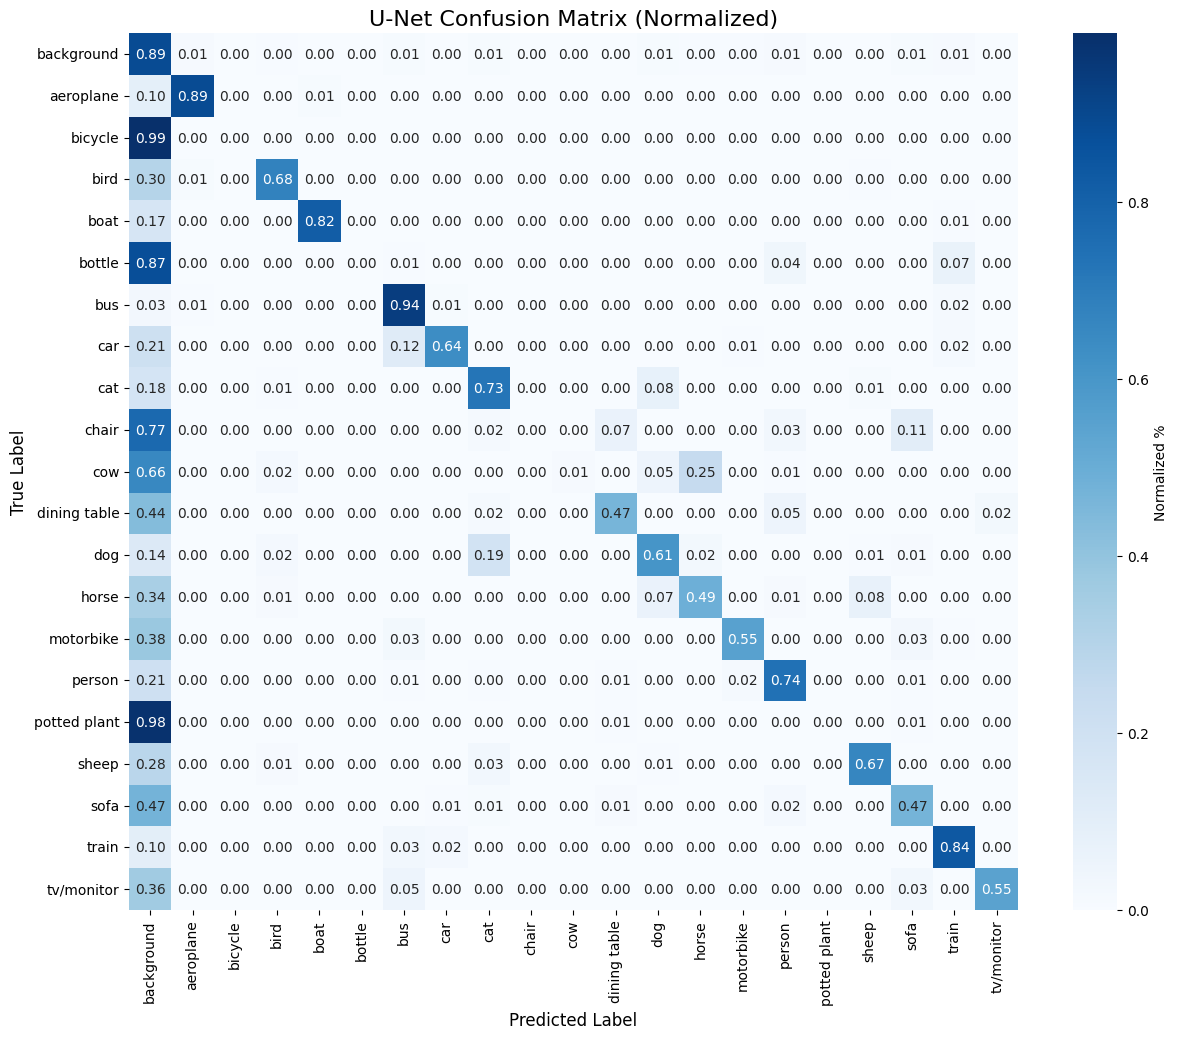

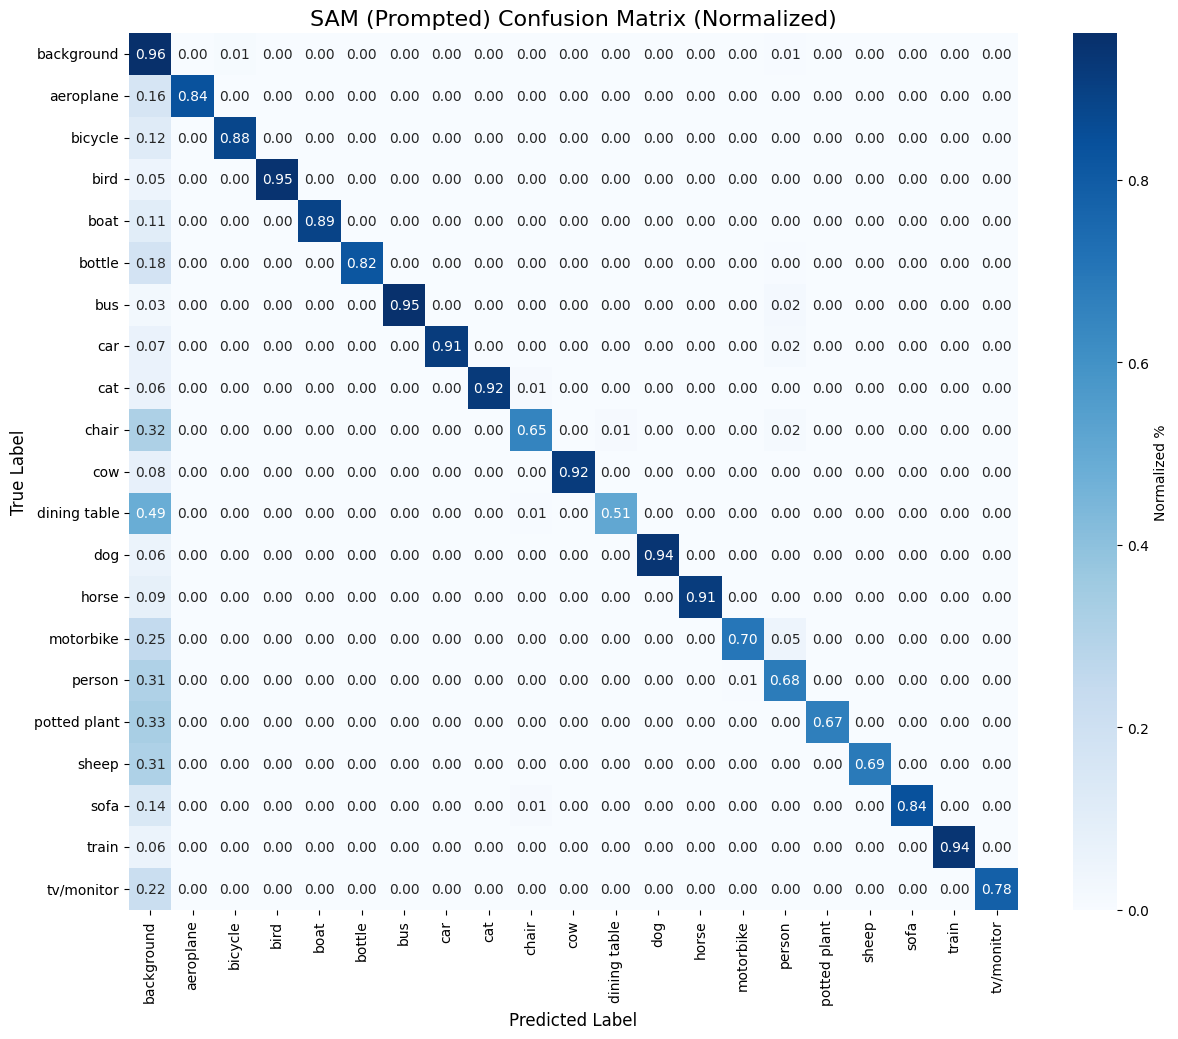

In [24]:
def plot_confusion_matrix(cm, title, class_names):
    """
    Plots a normalized confusion matrix with seaborn.
    Handles zero-division and dynamically adjusts figure size.
    """
    # Normalize the confusion matrix by row (true labels)
    with np.errstate(divide='ignore', invalid='ignore'):
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with 0

    # Dynamic figure sizing
    num_classes = len(class_names)
    figsize = (max(12, num_classes * 0.6), max(8, num_classes * 0.5))

    plt.figure(figsize=figsize)
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Normalized %'})
    plt.title(title, fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car",
    "cat", "chair", "cow", "dining table", "dog", "horse",
    "motorbike", "person", "potted plant", "sheep", "sofa",
    "train", "tv/monitor"
]

CM_CLASS_NAMES = ['background'] + VOC_CLASSES

# Plot U-Net Confusion Matrix
plot_confusion_matrix(unet_cm_total, "U-Net Confusion Matrix (Normalized)",
                      CM_CLASS_NAMES)

# Plot SAM Confusion Matrix
plot_confusion_matrix(sam_cm_total, "SAM (Prompted) Confusion Matrix (Normalized)",
                      CM_CLASS_NAMES)



Showing U-Net Multi-Class Predictions:


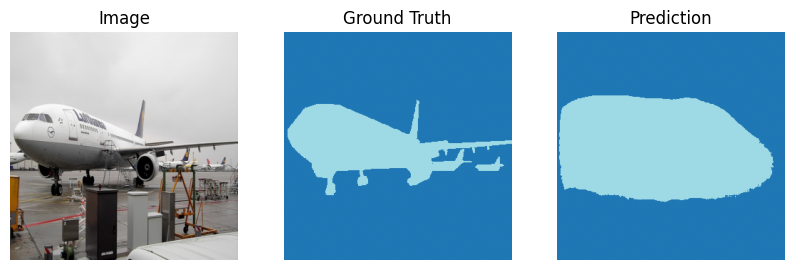

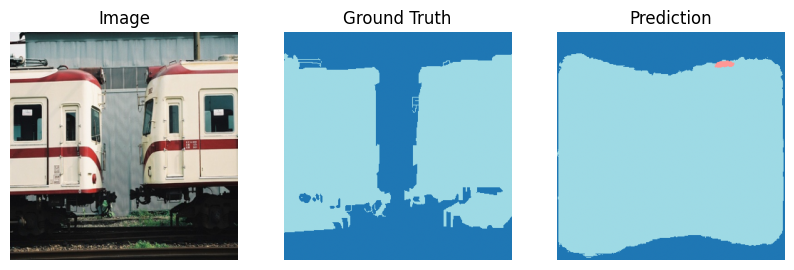

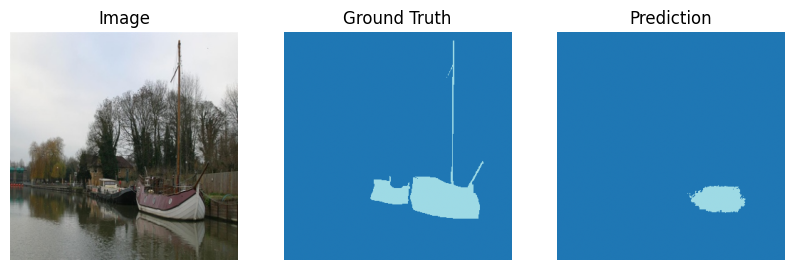

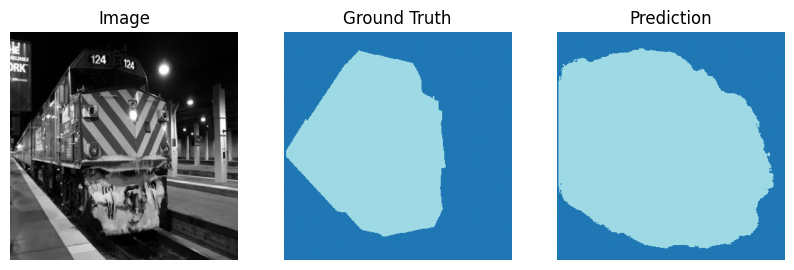

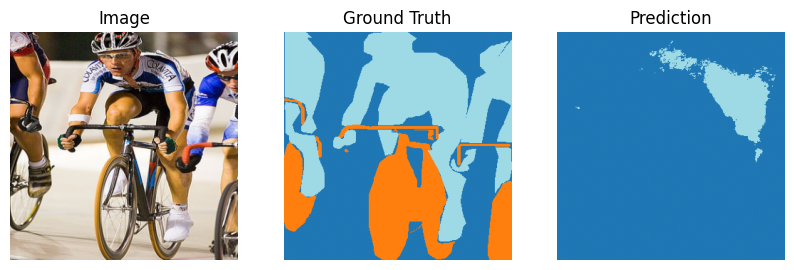

In [25]:
print("\nShowing U-Net Multi-Class Predictions:")
visualize_predictions(val_ds, model, num_samples=5)

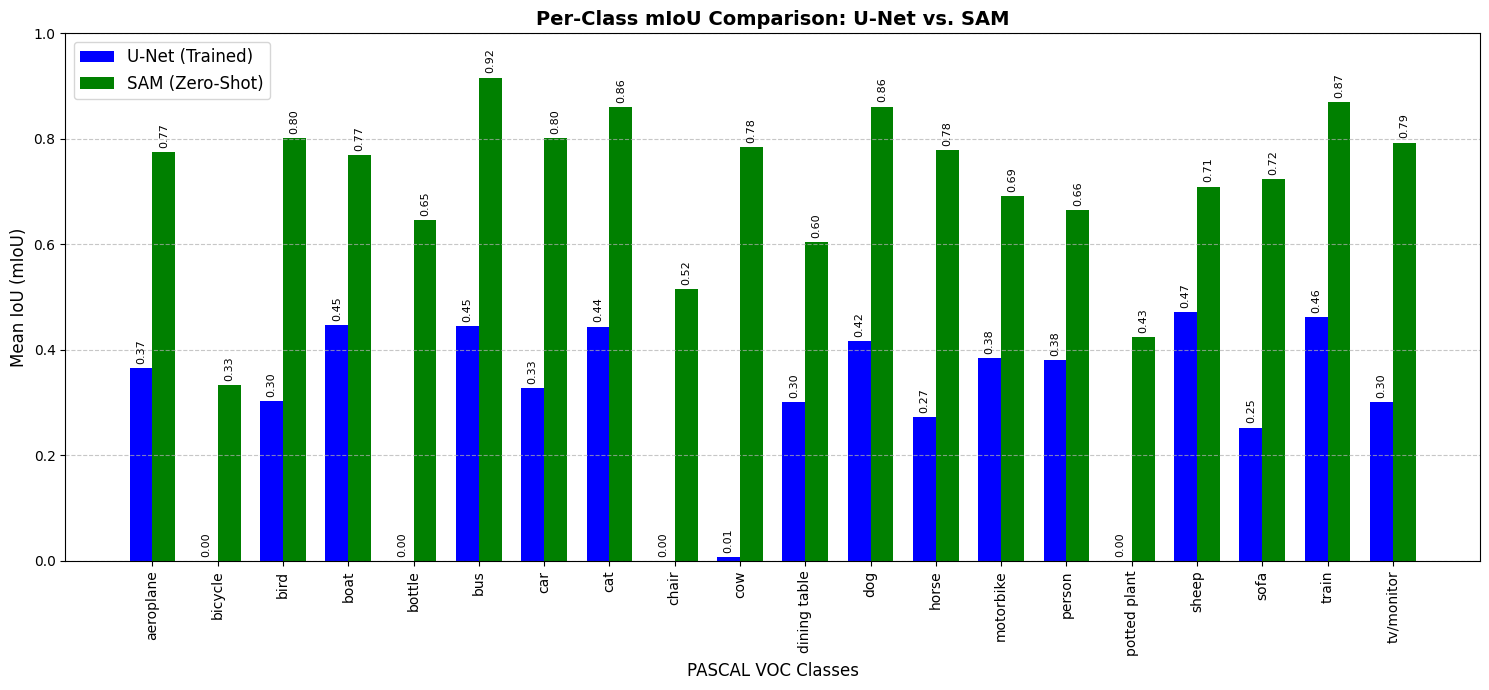

In [26]:

unet_miou_per_class = [np.nanmean(scores) if scores else np.nan for scores in unet_class_iou[1:]]
sam_miou_per_class = [np.nanmean(scores) if scores else np.nan for scores in sam_class_iou[1:]]


x = np.arange(len(VOC_CLASSES))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 7))

# Create bars for U-Net
rects1 = ax.bar(x - width/2, unet_miou_per_class, width,
                label='U-Net (Trained)', color='blue')

# Create bars for SAM
rects2 = ax.bar(x + width/2, sam_miou_per_class, width,
                label='SAM (Zero-Shot)', color='green')

# Add some text for labels, title and axes ticks
ax.set_ylabel('Mean IoU (mIoU)', fontsize=12)
ax.set_title('Per-Class mIoU Comparison: U-Net vs. SAM',
             fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(VOC_CLASSES, rotation=90, fontsize=10) # Rotate labels for readability
ax.set_xlabel('PASCAL VOC Classes', fontsize=12)
ax.legend(fontsize=12)

# Add a grid for easier reading
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, 1.0) # mIoU is between 0 and 1

# Optional: Add labels on top of bars
ax.bar_label(rects1, fmt='%.2f', padding=3, rotation=90, fontsize=8)
ax.bar_label(rects2, fmt='%.2f', padding=3, rotation=90, fontsize=8)

fig.tight_layout()  # Adjust layout to make room for labels
plt.show()

In [27]:
def visualize_comparison(model, predictor, dataset, index):
    """
    Generates a 4-panel comparison:
    1. Original Image
    2. Ground Truth Mask
    3. U-Net (Trained) Prediction
    4. SAM (Zero-Shot, Prompted) Prediction
    """
    model.eval()
    predictor.model.eval()

    # 1. Get Data
    img, gt_mask, img_vis = dataset[index] # img is (3, 320, 320) tensor

    # Prepare U-Net input
    img_tensor = img.unsqueeze(0).to(device)

    # Prepare Image for SAM and plotting
    # Convert from (C, H, W) tensor to (H, W, C) numpy array
    img_np = (img_vis.permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    # 2. U-Net Inference
    with torch.no_grad():
        unet_out = model(img_tensor)
        unet_pred_mask = torch.argmax(unet_out, dim=1).squeeze().cpu() # (320, 320)

    # 3. SAM (Prompted) Inference
    predictor.set_image(img_np)

    # We'll build a multi-class mask from SAM's binary outputs
    sam_final_mask = torch.zeros_like(gt_mask)

    # Iterate over each class (skip background)
    for c in range(1, num_classes):
        gt_class_mask = (gt_mask == c)

        # Only prompt if the object is actually in the image
        if gt_class_mask.sum() > 0:
            input_box = get_bbox_from_mask(gt_class_mask)

            if input_box is not None:
                with torch.no_grad():
                    masks, _, _ = predictor.predict(
                        point_coords=None,
                        point_labels=None,
                        box=input_box.cpu().numpy()[None, :],
                        multimask_output=False,
                    )

                # Resize SAM's mask and "stamp" it onto our final mask
                sam_mask_resized = torch.from_numpy(
                    np.array(Image.fromarray(masks[0]).resize((320, 320), Image.NEAREST))
                )

                # Where SAM's mask is true, set the class label
                sam_final_mask[sam_mask_resized > 0] = c

    # 4. Plotting
    plt.figure(figsize=(20, 6))

    # Define a consistent colormap for 21 classes
    cmap = 'tab20'
    vmin = 0
    vmax = 20

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("1. Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask.numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title("2. Ground Truth")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(unet_pred_mask.numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title("3. U-Net Prediction")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(sam_final_mask.numpy(), cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title("4. SAM (Prompted) Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

--- Visualization Example 1 ---


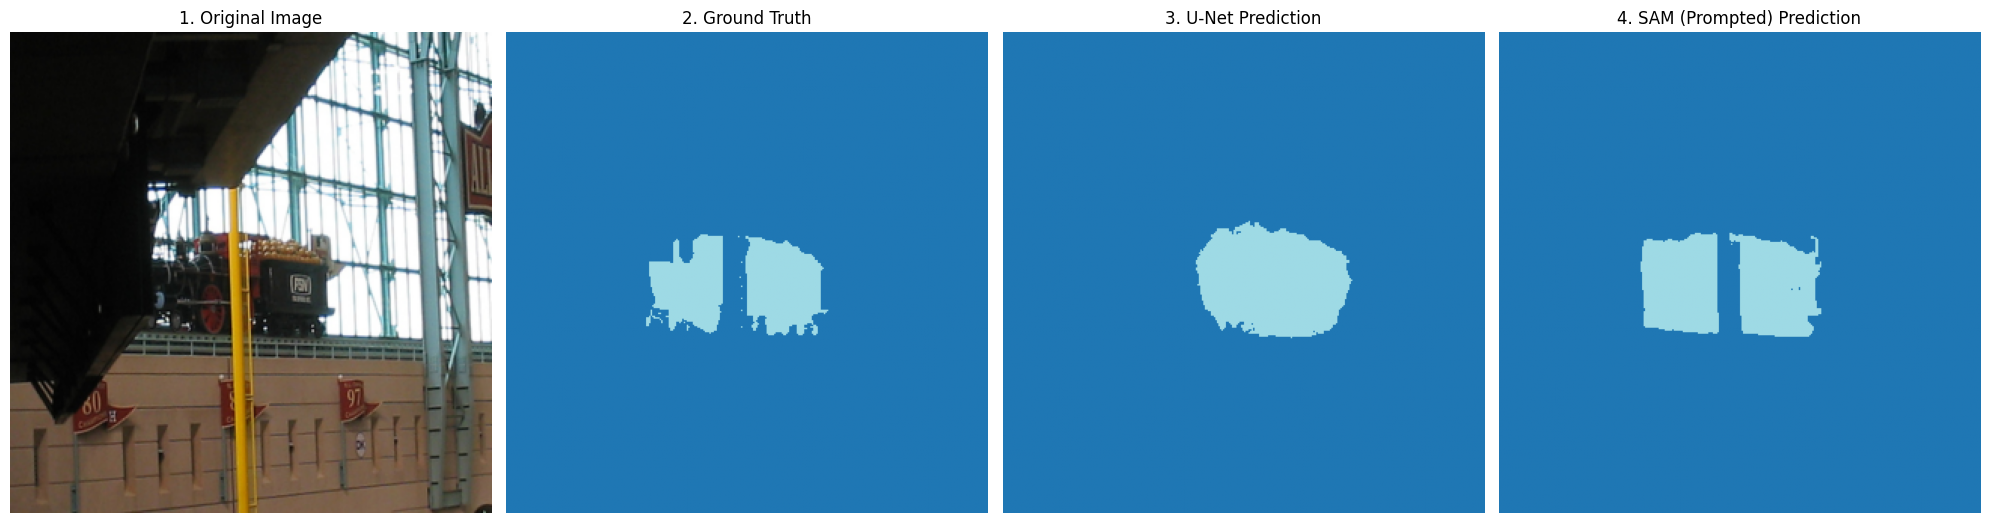

--- Visualization Example 2 ---


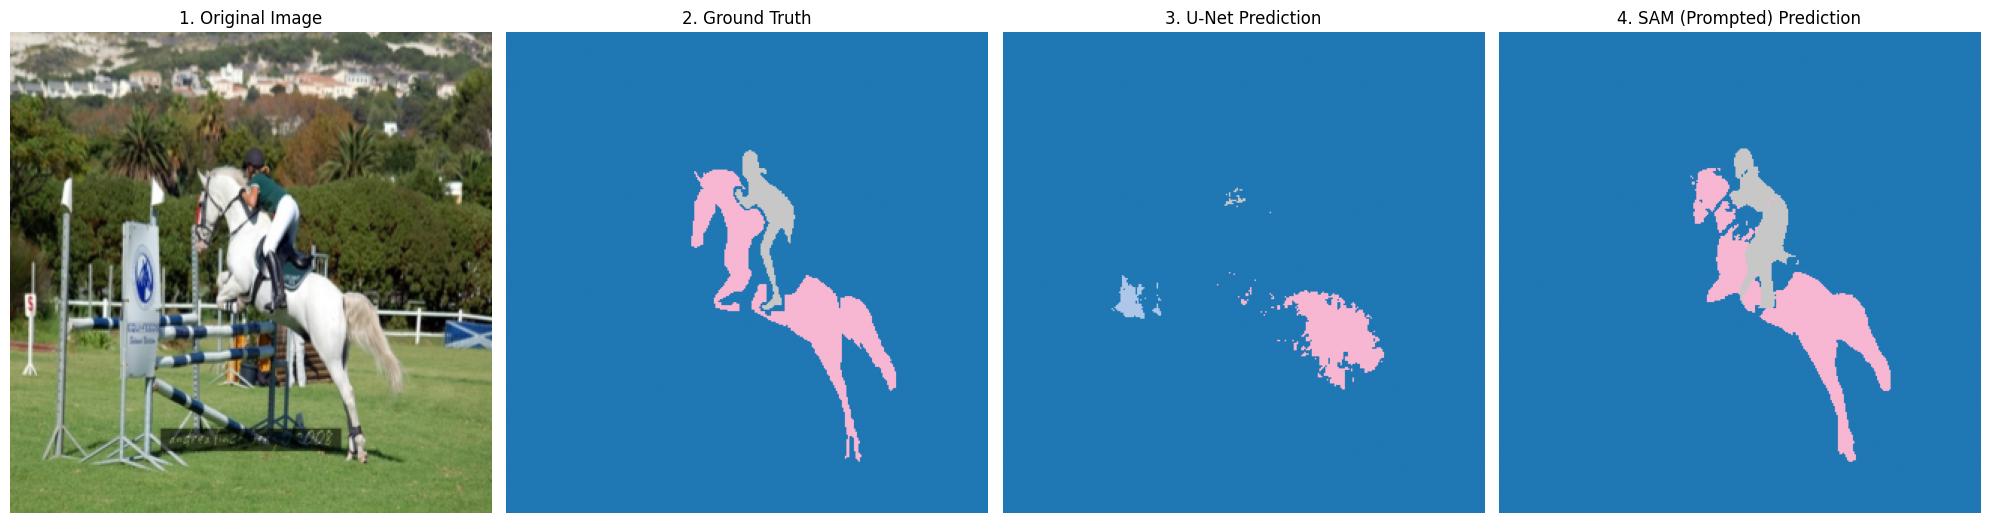

--- Visualization Example 3 ---


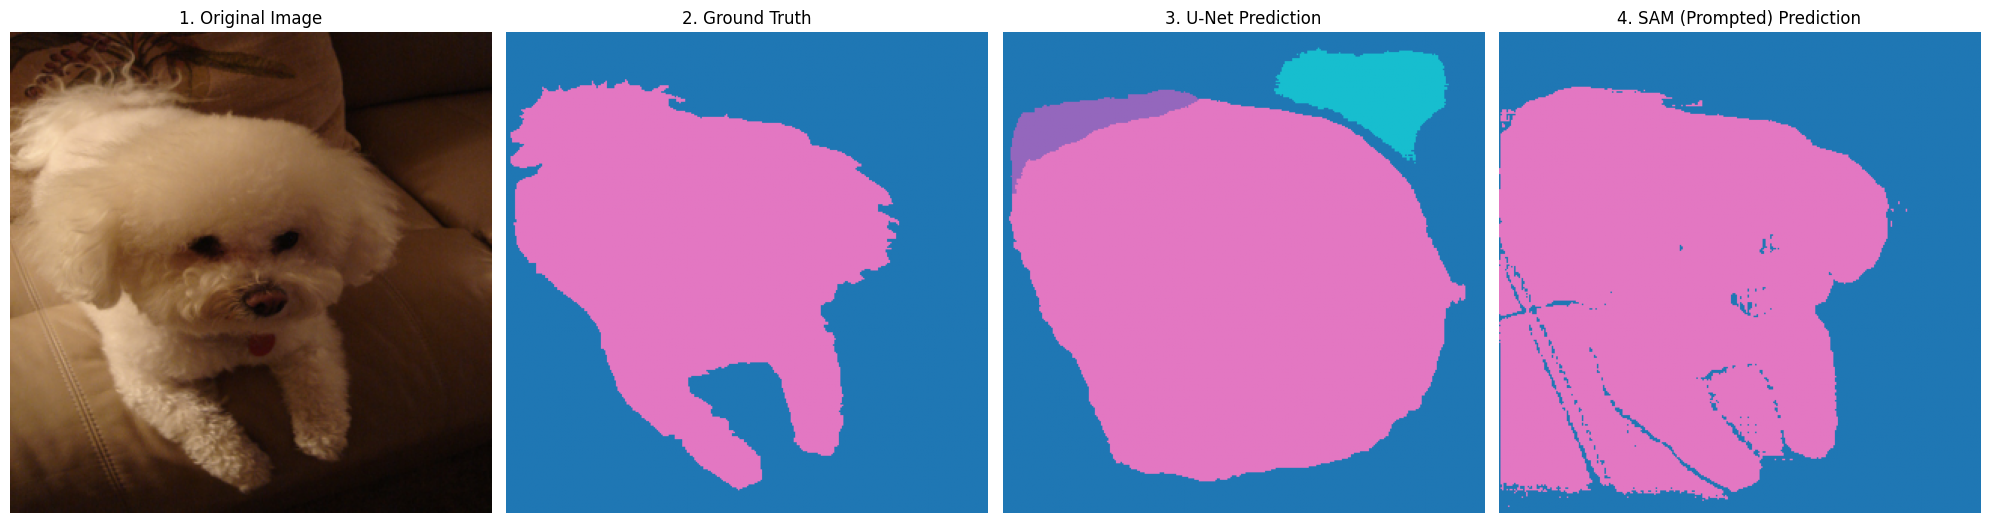

In [28]:

# Visualize a few examples from the test set
print("--- Visualization Example 1 ---")
visualize_comparison(model, predictor, test_subset, index=10)

print("--- Visualization Example 2 ---")
visualize_comparison(model, predictor, test_subset, index=25)

print("--- Visualization Example 3 ---")
visualize_comparison(model, predictor, test_subset, index=50)

--- Overlay Visualization Example ---


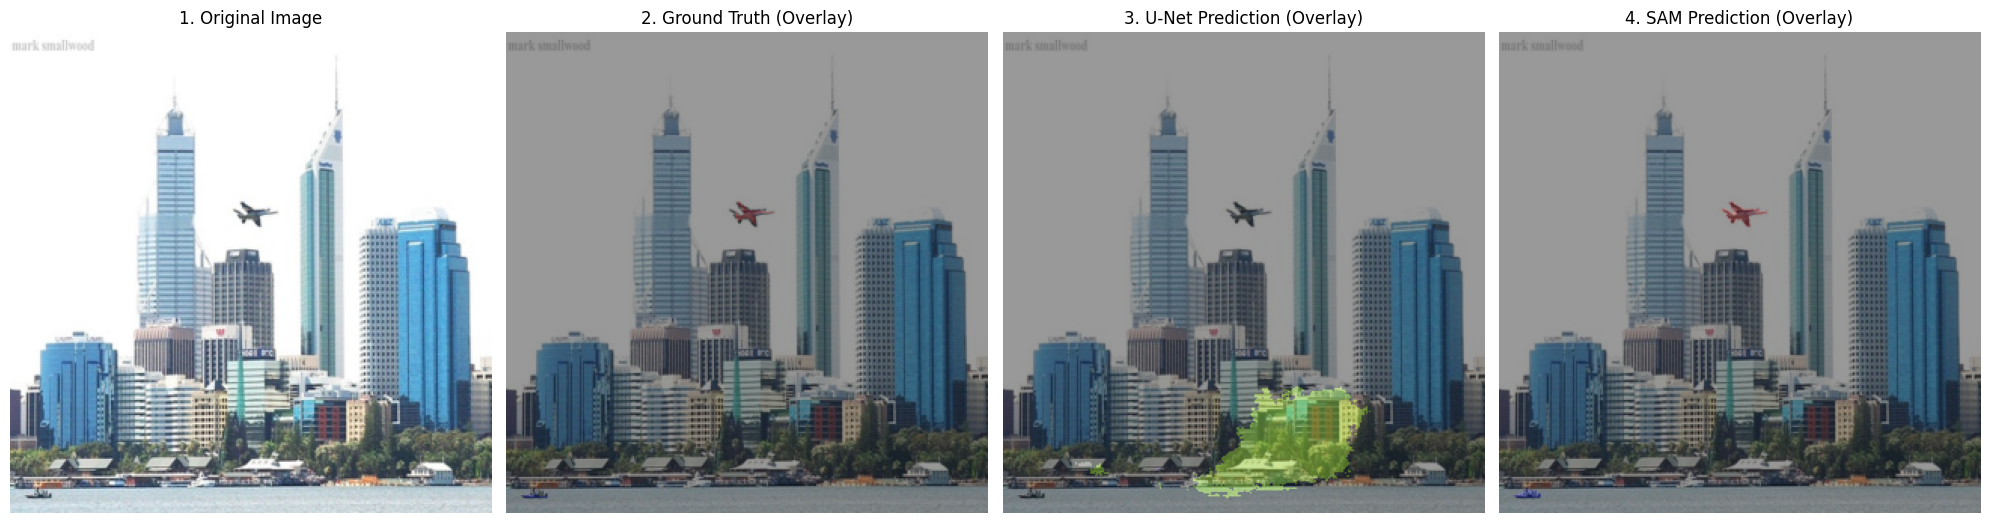

In [29]:

def visualize_overlay(model, predictor, dataset, index):
    """
    Generates a 4-panel comparison:
    1. Original Image
    2. Ground Truth (Overlay)
    3. U-Net Prediction (Overlay)
    4. SAM Prediction (Overlay)
    """
    model.eval()
    predictor.model.eval()


    img, gt_mask, img_vis = dataset[index] # Unpack all three values
    img_tensor = img.unsqueeze(0).to(device)
    img_np = (img_vis.permute(1, 2, 0).numpy() * 255).astype(np.uint8) # Use img_vis for original image

    # U-Net
    with torch.no_grad():
        unet_pred_mask = torch.argmax(model(img_tensor), dim=1).squeeze().cpu()

    # SAM
    predictor.set_image(img_np)
    sam_final_mask = torch.zeros_like(gt_mask)
    for c in range(1, num_classes):
        gt_class_mask = (gt_mask == c)
        if gt_class_mask.sum() > 0:
            input_box = get_bbox_from_mask(gt_class_mask)
            if input_box is not None:
                with torch.no_grad():
                    masks, _, _ = predictor.predict(
                        point_coords=None, point_labels=None,
                        box=input_box.cpu().numpy()[None, :],
                        multimask_output=False,
                    )
                sam_mask_resized = torch.from_numpy(
                    np.array(Image.fromarray(masks[0]).resize((320, 320), Image.NEAREST))
                )
                sam_final_mask[sam_mask_resized > 0] = c

    # Convert masks to RGB
    gt_rgb = mask_to_rgb(gt_mask.numpy(), VOC_COLORS)
    unet_rgb = mask_to_rgb(unet_pred_mask.numpy(), VOC_COLORS)
    sam_rgb = mask_to_rgb(sam_final_mask.numpy(), VOC_COLORS)

    # Blend images (Overlay)
    # uses cv2.addWeighted to blend: 60% image, 40% mask
    alpha = 0.6
    beta = 0.4

    # Ensure img_np is contiguous, required by cv2
    img_np_contiguous = np.ascontiguousarray(img_np, dtype=np.uint8)

    overlay_gt = cv2.addWeighted(img_np_contiguous, alpha, gt_rgb, beta, 0)
    overlay_unet = cv2.addWeighted(img_np_contiguous, alpha, unet_rgb, beta, 0)
    overlay_sam = cv2.addWeighted(img_np_contiguous, alpha, sam_rgb, beta, 0)

    # Plotting
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 4, 1)
    plt.imshow(img_np)
    plt.title("1. Original Image")
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(overlay_gt)
    plt.title("2. Ground Truth (Overlay)")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(overlay_unet)
    plt.title("3. U-Net Prediction (Overlay)")
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(overlay_sam)
    plt.title("4. SAM Prediction (Overlay)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

print("--- Overlay Visualization Example ---")
visualize_overlay(model, predictor, test_subset, index=30)